# Perform simulations and extract dihedral & feature data

### Input:
* `data/ala2_solv.pdb`

### Output:
* trajectory files: `workdir/ala2_xxns_xx.h5`
* energy out files: `workdir/ala2_xxns_xx.out`
* dihedrals: `workdir/dihedrals.npy`
* features: `workdir/features.npy`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mdtraj as md 
import openmm as mm
import openmm.unit as unit
from openmm.app import Simulation, ForceField, PDBFile, HBonds
import os

from src.filenames import FileNames
from src.util import SimulationParameters, pretty_print
from src.util import create_system
from src.util import save_npz, load_npz, write_pdb
from src.util import state_data_reporter, hdf5_reporter

# Mdshare dataset, $3\times 250$ns

https://markovmodel.github.io/mdshare/ALA2/#alanine-dipeptide

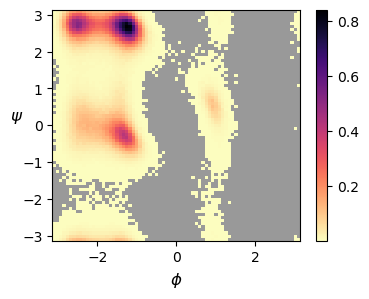

In [2]:
from src.data import MDShareData
from src.plots import plot_dihedrals_hist2d

sd = MDShareData('data/mdshare')

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_dihedrals_hist2d(fig, ax, sd.dihedrals)
fig.savefig('figures/dihedral-hist2d-mdshare.png', bbox_inches='tight')

# Vaccuum, 3 $\mu$s

In [3]:
p = SimulationParameters(
    simulation_time = 10 * unit.nanosecond, 
    report_interval_time = 1 * unit.picosecond,
    num_simulations = 300
)
fn = FileNames('data/ala2_vacuum', p.ns)
pretty_print(p)

simulation_time = 10 ns
report_interval_time = 1 ps
num_simulations = 300
temperature = 300 K
timestep = 0.002 ps
friction_coeff = 1 /ps
report_interval = 500
total_simulation_time = 3000 ns
ns = 10.0
total_ns = 3000.0


In [ ]:
pdb = PDBFile('data/ala2.pdb')
write_pdb(simulation, f'{fn.working_dir}/ala2.pdb')

forcefield = ForceField('amber99sb.xml')
system = forcefield.createSystem(pdb.topology, constraints=HBonds)

sim_start = 0
for sim_num in range(sim_start, p.num_simulations):
    print(f'starting simulation {sim_num + 1} of {p.num_simulations}')
    if sim_num == 0:
        start_positions = pdb.positions
    else:
        start_positions = load_npz(fn.final_positions(sim_num - 1))
    integrator = mm.LangevinIntegrator(p.temperature, p.friction_coeff, p.timestep)
    
    simulation = Simulation(pdb.topology, system, integrator)
    simulation.context.setPositions(start_positions)
    sdr = state_data_reporter(fn.out(sim_num), p.report_interval)
    hdr = hdf5_reporter(fn.h5(sim_num), p.report_interval)
    simulation.reporters.append(sdr)
    simulation.reporters.append(hdr)
    simulation.step(round(p.simulation_time / p.timestep))
    
    r = simulation.context.getState(getPositions=True).getPositions()
    save_npz(fn.final_positions(sim_num), r)
    for reporter in simulation.reporters:
        if hasattr(reporter, 'close'):
            reporter.close()

not recalculating data/ala2_vacuum/dihedrals.npy
not recalculating data/ala2_vacuum/features.npy
sd.dihedrals.shape = (2995978, 2)


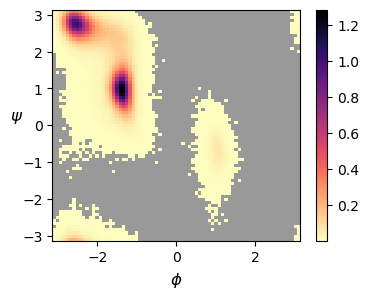

In [5]:
from src.data import OpenMMData
from src.plots import plot_dihedrals_hist2d

sd = OpenMMData(fn.working_dir)
sd.save_feature_data(fn.h5, p.num_simulations) #, recalculate=True)

print(f'{sd.dihedrals.shape = }')
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_dihedrals_hist2d(fig, ax, sd.dihedrals)
fig.savefig('figures/dihedral-hist2d-vacuum.png', bbox_inches='tight')

# Solvated, 150 ns, 0.05 ps report interval

This simulation is intended to capture transitions in high detail.  It also gives fairly good coverage of the dihedral space, which helps to characterize the eigenfunctions later on.  It sppears that the 3 $\mu$s simulation below does a better job of this, though.

In [6]:
p = SimulationParameters(
    simulation_time = 1.0 * unit.nanosecond, 
    report_interval_time = 0.05 * unit.picosecond,
    num_simulations = 150
)
fn = FileNames('data/ala2_solv.0.05ps', p.ns)
pretty_print(p)

simulation_time = 1.0 ns
report_interval_time = 0.05 ps
num_simulations = 150
temperature = 300 K
timestep = 0.002 ps
friction_coeff = 1 /ps
report_interval = 25
total_simulation_time = 150.0 ns
ns = 1.0
total_ns = 150.0


not recalculating data/ala2_solv/dihedrals.npy
not recalculating data/ala2_solv/features.npy
sd.dihedrals.shape = (3000000, 2)


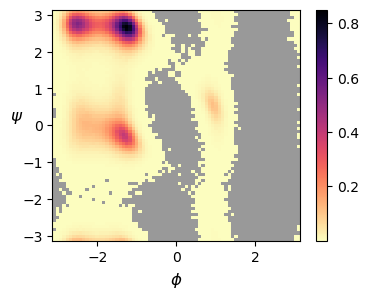

In [13]:
from src.data import OpenMMData
from src.plots import plot_dihedrals_hist2d

sd = OpenMMData(fn.working_dir)
sd.save_feature_data(fn.h5, p.num_simulations) # , recalculate=True)

print(f'{sd.dihedrals.shape = }')
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_dihedrals_hist2d(fig, ax, sd.dihedrals)

# Solvated, 3 $\mu$s

In [6]:
p = SimulationParameters(
    simulation_time = 10 * unit.nanosecond, 
    report_interval_time = 1 * unit.picosecond,
    num_simulations = 300
)
fn = FileNames('data/ala2_solv', p.ns)
pretty_print(p)

simulation_time = 10 ns
report_interval_time = 1 ps
num_simulations = 300
temperature = 300 K
timestep = 0.002 ps
friction_coeff = 1 /ps
report_interval = 500
total_simulation_time = 3000 ns
ns = 10.0
total_ns = 3000.0


In [3]:
pdb = PDBFile('data/ala2_solv.pdb')
forcefield = ForceField('amber99sb.xml', 'tip3p.xml')

sim_start = 12
for sim_num in range(sim_start, p.num_simulations):
    print(f'starting simulation {sim_num + 1} of {p.num_simulations}')
    if sim_num == 0:
        start_positions = pdb.positions
    else:
        start_positions = load_npz(fn.final_positions(sim_num - 1))
    system = create_system(forcefield, pdb.topology)
    integrator = mm.LangevinIntegrator(p.temperature, p.friction_coeff, p.timestep)
    
    simulation = Simulation(pdb.topology, system, integrator)
    simulation.context.setPositions(start_positions)
    sdr = state_data_reporter(fn.out(sim_num), p.report_interval)
    hdr = hdf5_reporter(fn.h5(sim_num), p.report_interval)
    simulation.reporters.append(sdr)
    simulation.reporters.append(hdr)
    simulation.step(round(p.simulation_time / p.timestep))
    
    r = simulation.context.getState(getPositions=True).getPositions()
    save_npz(fn.final_positions(sim_num), r)
    for reporter in simulation.reporters:
        if hasattr(reporter, 'close'):
            reporter.close()

starting simulation 13 of 300
starting simulation 14 of 300
starting simulation 15 of 300
starting simulation 16 of 300
starting simulation 17 of 300
starting simulation 18 of 300
starting simulation 19 of 300
starting simulation 20 of 300
starting simulation 21 of 300
starting simulation 22 of 300
starting simulation 23 of 300
starting simulation 24 of 300
starting simulation 25 of 300
starting simulation 26 of 300
starting simulation 27 of 300
starting simulation 28 of 300
starting simulation 29 of 300
starting simulation 30 of 300
starting simulation 31 of 300
starting simulation 32 of 300
starting simulation 33 of 300
starting simulation 34 of 300
starting simulation 35 of 300
starting simulation 36 of 300
starting simulation 37 of 300
starting simulation 38 of 300
starting simulation 39 of 300
starting simulation 40 of 300
starting simulation 41 of 300
starting simulation 42 of 300
starting simulation 43 of 300
starting simulation 44 of 300
starting simulation 45 of 300
starting s

sd.dihedrals.shape = (3000000, 2)


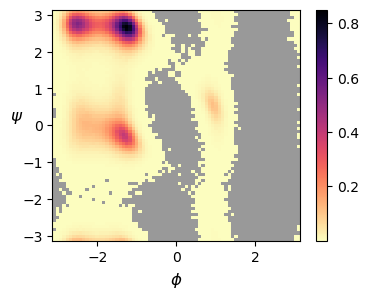

In [8]:
from src.data import OpenMMData
from src.plots import plot_dihedrals_hist2d

sd = OpenMMData(fn.working_dir)
sd.save_feature_data(fn.h5, p.num_simulations, recalculate=True)

print(f'{sd.dihedrals.shape = }')
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_dihedrals_hist2d(fig, ax, sd.dihedrals)
fig.savefig('figures/dihedral-hist2d-solv.png', bbox_inches='tight')